In [2]:
"""
OBJETIVO : Dividir los datasets princiaples en peuqeños datasets mas selectos, o solo modificaciones de los principales

TERMINOS: 
- DA = Data augmentation
- 01 = Datos entre 0 y 1
- 19 = Datos mayor a 1
- FDA = False data augemntation, consiste en cambiar el valor de preciptiacion para convertirlo de conforme a malo-
        
"""
Autor='Diego Paredes'

In [3]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cfw
import matplotlib.pyplot as plt

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import plotly.express as px

# Liberias estandar
import re
import time
import os

In [4]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [5]:
#Nombre de archivos
#dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
#_dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
#_dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
#_dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')

In [6]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 

# Archivos de datasets
dsName = 'dsCompletoPP_V2'

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']

In [7]:
#Archivos adicionales
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
FflagV2 = f'{path_base}/Archivos/Dataset/dsFLAGV2.csv'

imagenTest = 'D:/GOES/C08/2020/01/G16_C08_Cyl_20200101-0020.nc'
Fanalisis = f'{path_base}/Archivos/Reportes/Datos/analisis_Total.csv'

In [8]:
def visualizarEstaciones(df, name = '',imagenTest='', xCode=True, row='codigo'):
    if not imagenTest:
        imagenTest = 'D:/GOES/C08/2020/01/G16_C08_Cyl_20200101-0020.nc'
    
    ds = Dataset(imagenTest)
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    #lons, lats = np.meshgrid(lons, lats)
    
    Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfEstaciones = pd.read_csv(Festaciones)
    dfCod = df[row].unique()
    dfCod = pd.DataFrame({row:dfCod.tolist()})

    #Graficomos las estaciones para el ds de regresion
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(f'{name} - Peru ({len(dfCod)} estaciones)')
    ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

    for x in dfCod.index:
        if xCode:
            st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfCod[row][x]}']
        else:
            st = dfEstaciones[dfEstaciones['CODE'] == f'{dfCod[row][x]}']    
        if not st.empty:    
            x = st['LON']#.iloc[0]
            y = st['LAT']#.iloc[0]
            plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    

    ax.coastlines(resolution='110m')
    
    plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_{name}.png')
    plt.show()

In [9]:
def statsDS(df, name='ds', tipo='Clasificacion'):    
    print(f'           ESTADISCIAS DEL {name} \n')  
    print(f'Flags       : {df["flag"].unique()}')
    print(f'Estaciones  : {len(df["codigo"].unique())}')
    print(f'Totales     : {df["dato"].count()}')
    print(f'Ceros       : {df[df["dato"]==0]["dato"].count()}')    
    if tipo=='Regresion':
        print(f'Menor a 1   : {df[df["dato"]<1]["dato"].count()}')
        print(f'Mayor a 1   : {df[df["dato"]>1]["dato"].count()}')
    else:
        print(f'Clase 0(M02): {df[df["flag"]=="M0000002"]["dato"].count()}')
        print(f'Clase 1(C02): {df[df["flag"]=="C0000002"]["dato"].count()}')
    print(f'Maximo      : {df["dato"].max()}')
    print(f'Media       : {df["dato"].mean()}')
    print(f'STD         : {df["dato"].std()}')

    #_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
    #_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
    if tipo=='Clasificacion':
        df['flag'].hist(legend=True)
        plt.xlabel('FLAG')
        plt.ylabel('Cantidad')
        plt.title('Histograma de FLAG')
    else:
        df['dato'].hist(legend=True)   
        plt.xlabel('Valor')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Precipitacion')
    plt.show()

In [10]:
"""
Metodos para balancear las clases en los datasets
"""

'\nMetodos para balancear las clases en los datasets\n'

In [11]:
# Aplica data augmentation en un df, aumentando solo la clase (columna) minoritaria maximo 3 (DA) veces
def applyDA(df, columna='clase', DA=3):
    df['DA'] = 0
    dfs = [df[df[columna]==0], df[df[columna]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    
    df_list = [dfs[posM]]
    # Clase minoritaria = M^1
    # Se va aumentar lm    
    
    for i in range(DA):        
        dfMenor = dfs[posM^1].copy()
        dfMenor['DA'] = i
        df_list.append(dfMenor)
    
     
    train = pd.concat(df_list, axis=0)    
    
    return train

In [12]:
# Aplica false data augmentation en un df, aumentando solo la clase (columna) minoritaria 
# con el FDA porciente de las precipitaciones leves (<umb_leve) de la clase mayoritaria 
# Si delete = True, lo convertido de la clase mayoritaria, se borra de la clase mayoritaria
def applyFA(df, columna='clase', FDA=0.1, umbralSep = 20, delete=True , umb_leve = 1, random_state=11):  
    # No se le aplicado DFA al dataset
    df['DFA'] = 0
    
    # Encontramos la clase mayoritaria y minoritaria
    dfs = [df[df[columna]==0], df[df[columna]==1]]
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
     # Calculamos los grupos de preciptiacion leve y fuerte en la clase mayoritaria
    dfLeve = dfs[posM].copy()
    dfLeve = dfLeve[dfLeve['dato']<umb_leve]    
    
    dfAlta = dfs[posM].copy()    
    dfAlta = dfAlta[dfAlta['dato']>=umb_leve]
    
    cantNeeded = len(dfLeve) * FDA
    
    print(f'Cantidad de clase mayoritaria : {len(dfs[posM])}')
    print(f'Cantidad de clase minoritaria : {len(dfs[posM^1])}')
    print(f'Total a aumentar              : {cantNeeded}')
    print(f'Cantidad leve (Mayoritaria)   : {len(dfLeve)}')
    print(f'Cantidad alta (Mayoritaria)   : {len(dfAlta)}')
    
    
            
    # Obtenemso el DS de DFA
    if delete:        
        print(f'Cantidad a tomar de leve      : {FDA}')
        dfDFAleve, dfLeve = train_test_split(dfLeve, train_size = FDA, random_state=random_state)# dfLeve.sample(frac=fracL)
    else:
        dfDFAleve = dfLeve.sample(n=int(cantNeeded))
    
    dfDFAleve['dato'] = dfDFAleve['dato'] + umbralSep
    dfDFAleve['clase'] = 0
    dfDFAleve['flag'] = 'M0000002'
    dfDFAleve['DFA'] = 1
    
    
    if delete:
        train = pd.concat([dfAlta,dfLeve,dfDFAleve,dfs[posM^1]])
        print(f'Diferencia final              : { len(dfAlta) + len(dfLeve) - len(dfDFAleve) - len(dfs[posM^1])}')

        
    return train

In [13]:
# Metodo de eliminar datos de la clase mayoritaria, eliminas los valores vajos (mas cantidad)
def disminuirMayoritario(df, porc=0.2, umbralSep = 1, columna='clase'):
    dfs = [df[df[columna]==0], df[df[columna]==1]]
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    # Calculamos los grupos de preciptiacion leve y fuerte en la clase mayoritaria
    dfLeve = dfs[posM].copy()
    dfLeve = dfLeve[dfLeve['dato']<umbralSep]    
    
    dfAlta = dfs[posM].copy()    
    dfAlta = dfAlta[dfAlta['dato']>=umbralSep]    
    
    dfDFLeve = dfLeve.sample(frac=porc)
    #dfDFAlta = dfAlta.sample(frac=porc)
    
    train = pd.concat([dfDFLeve,dfAlta,dfs[posM^1]])
    
    return train

In [14]:
# Aplica el metodo de split, ademas este split se realiza tambien balanceando los niveles de precipiacion en cada grupo
def splitTrainDS(_dataset, redTipo, path_base, newDir='Split', comentario=' ', nivel_dato = ['umb1' , 6], random_state=11):
    # Vamos a usar stratify de sklearn para tener una distribucion de estaciones adecuada
    _dataset['stratify'] = (_dataset[nivel_dato[0]] > nivel_dato[1]).astype(int)
    
    tipo = redTipo[0]
    output = redTipo[1]
    
    # Separamos clase mayoritaria de minoritaria
    dfs = [_dataset[_dataset[output]==0], _dataset[_dataset[output]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    lM = len(dfs[posM])
    lm = len(dfs[posM^1])
    len_total = len(_dataset)
    
    print('Cantidad Total : ', len_total)
    print('Cantidad clase minoritaria : ',lM)
    print('Cantidad clase mayoritaria : ',lm)
    # Creamos el directorio
    try:
        path = os.path.join(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/', newDir)
        os.mkdir(path)        
    except FileExistsError:
        pass
    except:
        print(f"No se pudo crear la carpeta {newDir}")
    
    
    # Verificamos la cantidad de datasets a crear
    n = int(lM/lm) + (lM % lm > 0)
    splitted = []
    
    # Guaradamos los datasets
    print(f'Se va dividr el dataset en {n} partes')
    
    ds_may_splitted = dfs[posM].copy()
    for i in range(n):
        # Para el ultimo dataset, escojemos parte del primero
        if i == (n-1):
            continue
            cant_final = lm-len(ds_may_splitted)
            ds_set_sobra = splitted[0].sample(n=(cant_final))
            splitted.append(pd.concat([ds_may_splitted,ds_set_sobra,dfs[posM^1]], ignore_index=True))        
            
        ds_may_splitted, ds_set =  train_test_split(ds_may_splitted, test_size=(lm/len(ds_may_splitted)), 
                                                 shuffle=True, stratify=ds_may_splitted['stratify'], random_state=random_state)        
        splitted.append(pd.concat([ds_set,dfs[posM^1]], ignore_index=True))
        
            
        
    for i, df in enumerate(splitted):
        df.to_csv(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/{output.upper()}_TrainDS_{i}.csv')        
 
    text_comentario = open(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/comentario.txt', "w")
    text_comentario.write(comentario) 
    text_comentario.close()
    
    return splitted

           ESTADISCIAS DEL ClaseVFinal_M0 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 151
Totales     : 26308
Ceros       : 0
Clase 0(M02): 614
Clase 1(C02): 25694
Maximo      : 337.5
Media       : 1.8983320662916223
STD         : 8.021763744019845


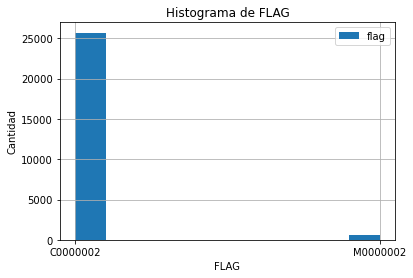

In [15]:
# Leemos el datasets de entrenamiento Clasifiacion
dsV_ = 'ClaseVFinal_M0'
fileTrain = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/{dsV_}_TrainDS.csv'

dsTrain = pd.read_csv(fileTrain)
statsDS(dsTrain, name=dsV_)

In [16]:
dsTrain['flagV2'].unique()

array(['D02', 'D01', 'C01'], dtype=object)

In [18]:
dsTrain[dsTrain['flag']=='M0000002']['codigo'].nunique() , dsTrain[dsTrain['flag']=='C0000002']['codigo'].nunique()

(27, 150)

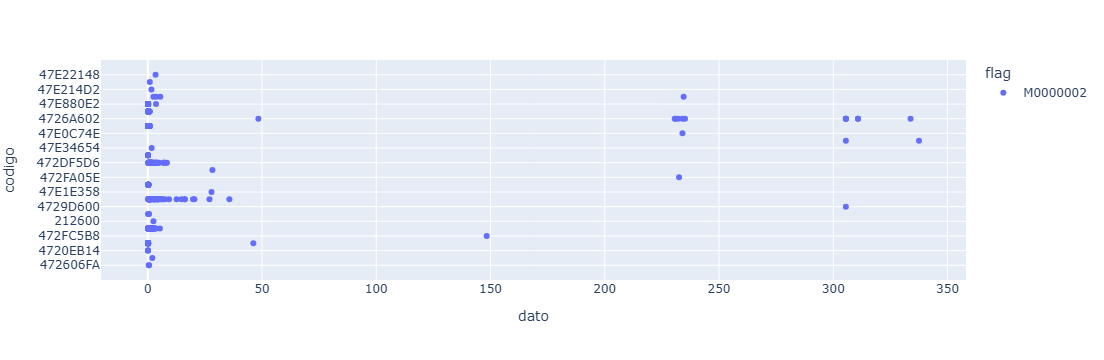

In [20]:
px.scatter(dsTrain[dsTrain['flag']=='M0000002'],x='dato', y='codigo', color='flag')

In [ ]:
"""
DS_V9_REG: No DA, Regresion
"""

In [ ]:
### DS CLasificacion V3
com = f"No DA, Regresion"
name = 'V9_Regresion'

train_balanced = dsTrain.copy()
#train_balanced = applyFA(train_balanced, FDA=0.01, umbralSep = 20, delete=True , umb_leve = 1)
#train_balanced = applyDA(train_balanced, columna='clase', DA=8)
train_balanced = splitTrainDS(train_balanced,['Clasificacion','clase'], path_base, newDir=name, comentario=com, random_state=11) 

# Visualimamos un datasets
visualizarEstaciones(train_balanced[0], name = name,xCode=True, row='codigo')
statsDS(train_balanced[0], name=name)

In [18]:
"""
DS_V63:Ceros True DA 8 con split, estaciones balanceado con umbral 1  (corte en 6)
"""

'\nDS_V63:Ceros True DA 8 con split, estaciones balanceado con umbral 1  (corte en 6)\n'

Cantidad Total :  30606
Cantidad clase minoritaria :  25694
Cantidad clase mayoritaria :  4912
Se va dividr el dataset en 6 partes


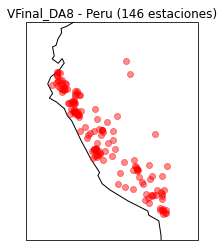

           ESTADISCIAS DEL VFinal_DA8 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 146
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.5875895765472325
STD         : 33.9436619607764


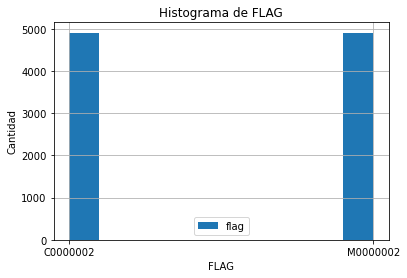

In [21]:
### DS CLasificacion V3
com = f"Clase VFinal: DA 8"
name = 'VFinal_DA8'

train_balanced = dsTrain.copy()
#train_balanced = applyFA(train_balanced, FDA=0.01, umbralSep = 20, delete=True , umb_leve = 1)
train_balanced = applyDA(train_balanced, columna='clase', DA=8)
train_balanced = splitTrainDS(train_balanced,['Clasificacion','clase'], path_base, newDir=name, comentario=com, random_state=11) 

# Visualimamos un datasets
visualizarEstaciones(train_balanced[0], name = name,xCode=True, row='codigo')
statsDS(train_balanced[0], name=name)

           ESTADISCIAS DEL VFinal_0 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 146
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.5875895765472325
STD         : 33.9436619607764


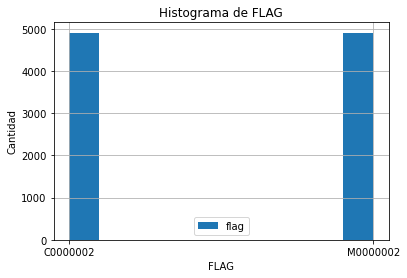

           ESTADISCIAS DEL VFinal_1 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 142
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.561688721498372
STD         : 33.94825143530999


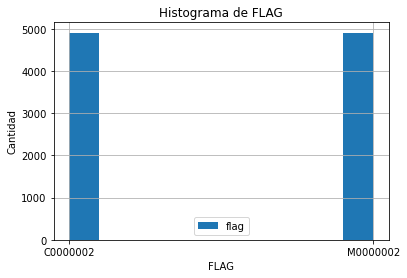

           ESTADISCIAS DEL VFinal_2 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 145
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.618853827361565
STD         : 33.95096285923169


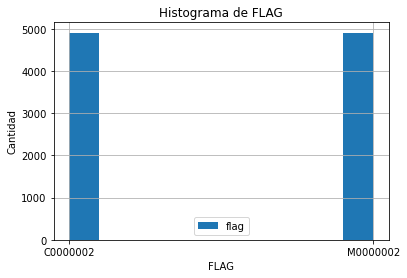

           ESTADISCIAS DEL VFinal_3 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 148
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.625896783387622
STD         : 33.957885520084254


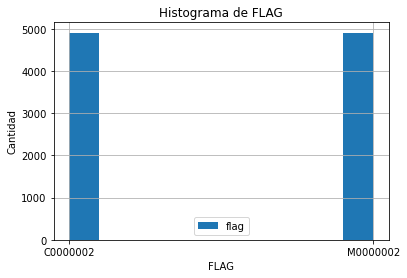

           ESTADISCIAS DEL VFinal_4 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 147
Totales     : 9824
Ceros       : 0
Clase 0(M02): 4912
Clase 1(C02): 4912
Maximo      : 337.5
Media       : 5.607122353420196
STD         : 33.9522336595437


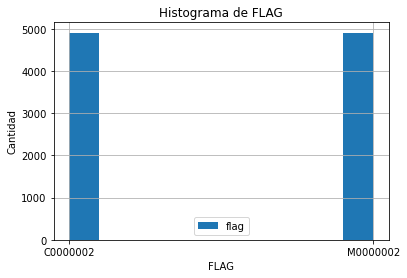

In [25]:
for n, ds in enumerate(train_balanced):
    statsDS(ds, name=f'VFinal_{n}')

<AxesSubplot:>

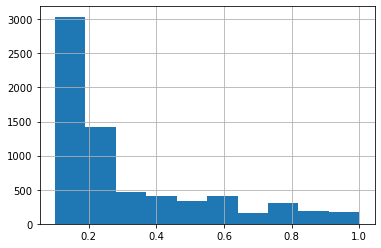

In [23]:
ds = train_balanced[0]
ds[ds['dato']<=1]['dato'].hist() 

<AxesSubplot:>

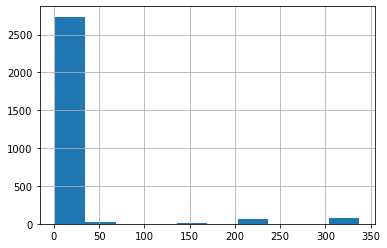

In [24]:

ds[ds['dato']>1]['dato'].hist()